![](https://breakingtech.it/wp-content/uploads/2018/04/twitter-moments-1.jpg)

## What's in the notebook?
- Full Exploratory Data Analysis (EDA)
- Data Cleaning
- Evaluation
    - BL Models (majority model + tfidf & logreg)
    - Gradient Boosting
    - Simple RNN
    - Glove Bi-LSTM
    - BERT + sigmoid
    - Ensemble (BERT + 10 shallow classifiers)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from sklearn.preprocessing import LabelEncoder
## ADD STOPWORDS
stop = set(list(stop) + ["http","https", "s", "nt", "m"])


Using TensorFlow backend.


In [2]:
def load_training(training_path="/kaggle/input/nlp-getting-started/train.csv"):
    df = pd.read_csv(training_path)
    
    print(df.head(10))
    return df

df = load_training()

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   
8  14     NaN      NaN  There's an emergency evacuation happening now ...   
9  15     NaN      NaN  I'm afraid that the tornado is coming to our a...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1  


# Data Analisys
In the following we're gonna see some data analysis on the corpus. 

Specifically:
- General dataset infos
    - Number of samples
    - Data Columns 
    - Class Label Distributiom
- Text analysis
    - Number of characters in tweets
    - Number of words in a tweet
    - Average word lenght in a tweet
    - Word distribution
    - Hashtag Analysis
    - KW and Location Analysis

## General dataset information
Here we show the number of samples, the input data columns and the class label distributiom

-Number of samples: 7613
-Input data columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
-Class label distribution
--Number of positive samples: 3271
--Number of negative samples: 4342
--Plot of Y distributions


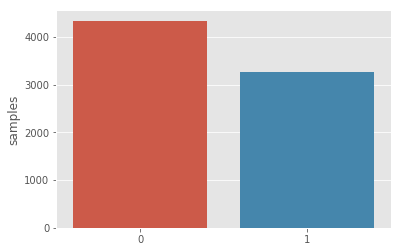

In [3]:
print("-Number of samples: {}".format(len(df)))
print("-Input data columns: {}".format(df.columns))
print("-Class label distribution")
print("--Number of positive samples: {}".format(len(df.loc[df['target'] == 1])))
print("--Number of negative samples: {}".format(len(df.loc[df['target'] == 0])))
print("--Plot of Y distributions")
x=df.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

def plot_hist_classes(to_plot, _header):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    df_len = to_plot(1)
    ax1.hist(df_len,color='red')
    ax1.set_title('Negative Tweets [disasters]')
    df_len = to_plot(0)
    ax2.hist(df_len,color='green')
    ax2.set_title('Positive Tweets [good posts]')
    fig.suptitle(_header)
    plt.show()
    plt.close()
    



## Text analysis
Insights on number of character and words in tweets, word lenght distribution, and word distribution.

-Number of characters in tweets


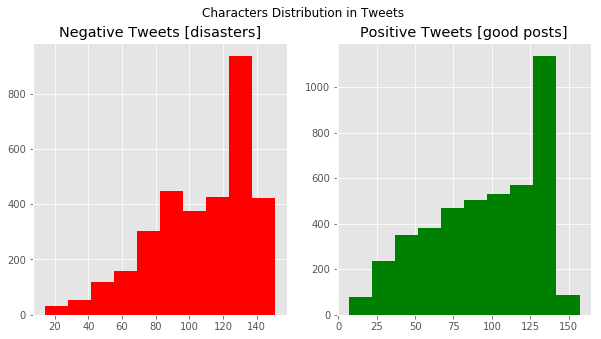

-Number of words in a tweet


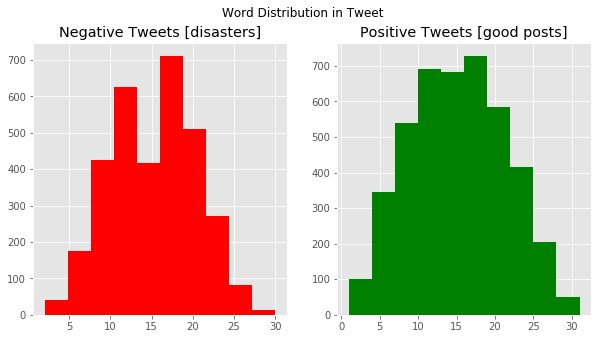

-Average word lenght in a tweet


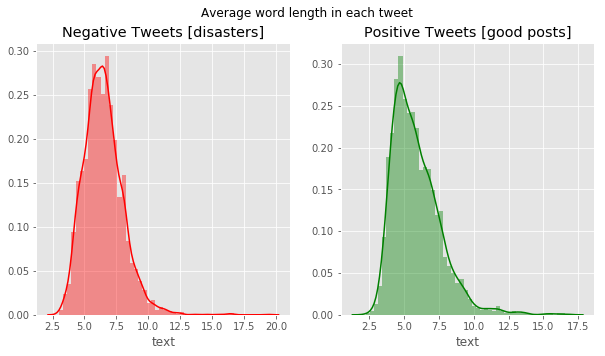

-Word distribution
-- Positive Class
      Frequency
Word           
:          3676
#          1703
.          1085
@           905
?           762
...         637
-           397
!           330
'           295
's          276
-- Negative Class
      Frequency
Word           
:          3030
?          2364
.          1882
@          1854
#          1700
!           843
's          515
...         426
'           400
-           388


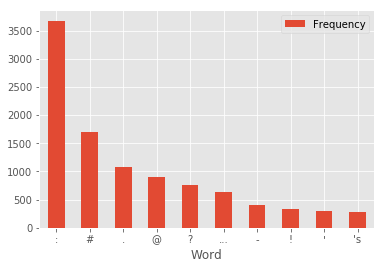

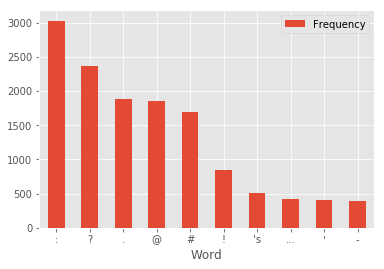

In [4]:
def show_word_distrib(target=1, field="text"):
    txt = df[df['target']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stop) 
    
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)
    matplotlib.style.use('ggplot')

    rslt.plot.bar(rot=0)
    
print("-Number of characters in tweets")
def to_plot(_target):
    return df[df['target']==_target]['text'].str.len()

    
plot_hist_classes(to_plot, _header='Characters Distribution in Tweets')


print("-Number of words in a tweet")
def to_plot(_target):
    return df[df['target']==_target]['text'].str.split().map(lambda x: len(x))
def how_to_plot(**kwargs):
    ax1.hist(df_len,**kwargs)
plot_hist_classes(to_plot, _header='Word Distribution in Tweet')


print("-Average word lenght in a tweet")
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Negative Tweets [disasters]')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Positive Tweets [good posts]')
fig.suptitle('Average word length in each tweet')
plt.show()

print("-Word distribution")

top_N = 10

print("-- Positive Class")

show_word_distrib(target=1, field="text")

print("-- Negative Class")
show_word_distrib(target=0, field="text")



## Hashtag analysis
Small analysis done on the hashtags, to check it's possible discriminator capability for this task.

-Hashtag Analysis 
-Number of tweets with hashtags: 7613
-- Hashtag distribution in positive samples 
            Frequency
Word                 
,                 784
news               56
hiroshima          22
earthquake         19
hot                13
prebreak           13
best               13
japan              11
india              10
yyc                10
breaking            9
worldnews           9
world               9
isis                9
sismo               9
abstorm             9
islam               9
disaster            8
wildfire            8
terrorism           8
-- Hashtag distribution in negative samples 
              Frequency
Word                   
,                   803
nowplaying           21
news                 20
hot                  18
prebreak             17
best                 17
gbbo                 14
jobs                 14
islam                14
job                  12
hiring               10
fashion               9
edm                   8
dnb      

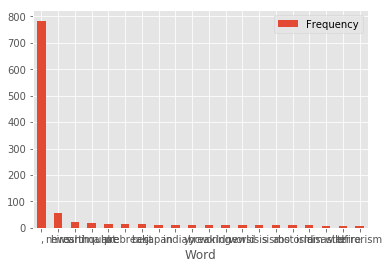

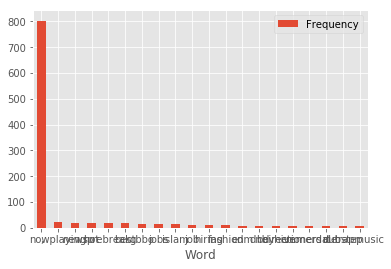

In [5]:
print("-Hashtag Analysis ")
def find_hashtags(tweet):
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or None

def add_hashtags(df):
    from sklearn.feature_extraction.text import CountVectorizer
    
    df['hashtag'] = df["text"].apply(lambda x: find_hashtags(x))
    df['hashtag'].fillna(value="no", inplace=True)
    
    return df
    
top_N = 20

df = add_hashtags(df)
_l = len([v for v in df.hashtag.values if isinstance(v, str)])
print("-Number of tweets with hashtags: {}".format(_l))
print("-- Hashtag distribution in positive samples ")
show_word_distrib(target=1, field="hashtag")

print("-- Hashtag distribution in negative samples ")
show_word_distrib(target=0, field="hashtag")


#There is too much intersection between hashtag in positive and negative samples, meaning that an
#hashtag approach will not work that well.

# KW and Location analysis


In [6]:
#Remove the encoded space character for keywords, since appears a lot of times and is junk
df['keyword'] = df['keyword'].map(lambda s: s.replace('%20', ' ') if isinstance(s, str) else s)

un_KW  = {kw for kw in df['keyword' ].values if isinstance(kw, str)}
tot_KW = len(df) - len(df[df["keyword" ].isna()])

un_LOC = {lc for lc in df['location'].values if isinstance(lc, str)}
tot_LOC =  len(df) - len(df[df["location"].isna()])

print("Unique KW: {}".format(len(un_KW)))
print("Out of: {}".format(tot_KW))
print("Samples with no KW: {}".format(len(df[df['keyword'].isna()])))


print("Unique LOC: {}".format(len(un_LOC)))
print("Out of: {}".format(tot_LOC))
print("Samples with no Loc: {}".format(len(df[df['location'].isna()])))


#LOCATION IS TOO SPARSE TO BE USED.



Unique KW: 221
Out of: 7552
Samples with no KW: 61
Unique LOC: 3341
Out of: 5080
Samples with no Loc: 2533


In [7]:
disaster_keywords = [kw for kw in df.loc[df.target == 1].keyword]
regular_keywords = [kw for kw in df.loc[df.target == 0].keyword]

disaster_keywords_counts = dict(pd.DataFrame(data={'x': disaster_keywords}).x.value_counts())
regular_keywords_counts = dict(pd.DataFrame(data={'x': regular_keywords}).x.value_counts())

all_keywords_counts =  dict(pd.DataFrame(data={'x': df.keyword.values}).x.value_counts())

# we sort the keywords so the most frequents are on top and we print them with relative
# occurrences in both classes of tweets:

for keyword, _ in sorted(all_keywords_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("> KW: {}".format(keyword))
    print("-- # in negative tweets: {}".format(disaster_keywords_counts.get(keyword, 0)))
    print("-- # in positive tweets: {}".format(regular_keywords_counts.get(keyword, 0)))
    print('--------')


#Many KWs in negative tweets are also present in positive ones, meaning that a KW approach is most likely to not work
#The same result was given by the hashtag analysis.

> KW: fatalities
-- # in negative tweets: 26
-- # in positive tweets: 19
--------
> KW: armageddon
-- # in negative tweets: 5
-- # in positive tweets: 37
--------
> KW: deluge
-- # in negative tweets: 6
-- # in positive tweets: 36
--------
> KW: sinking
-- # in negative tweets: 8
-- # in positive tweets: 33
--------
> KW: damage
-- # in negative tweets: 19
-- # in positive tweets: 22
--------
> KW: harm
-- # in negative tweets: 4
-- # in positive tweets: 37
--------
> KW: body bags
-- # in negative tweets: 1
-- # in positive tweets: 40
--------
> KW: siren
-- # in negative tweets: 5
-- # in positive tweets: 35
--------
> KW: fear
-- # in negative tweets: 5
-- # in positive tweets: 35
--------
> KW: collided
-- # in negative tweets: 23
-- # in positive tweets: 17
--------


# Data Cleaning
Here we are gonna clean the DF.
Specifically, we clean:
- stopwords (Kept cause removing them cause drop of performances)
- URL 
- HTML 
- emoji 
- punctuation

-- Word distrig Positive Class
            Frequency
Word                 
fire              178
news              136
via               121
disaster          117
california        111
suicide           110
police            107
amp               106
people            105
killed             93
like               92
hiroshima          86
storm              85
crash              84
fires              84
us                 81
families           81
train              79
emergency          76
buildings          75
-- Word distrib Negative Class
        Frequency
Word             
like          253
im            243
amp           192
new           168
get           163
dont          141
one           128
body          112
via            99
would          97
video          96
got            91
people         91
love           89
2              86
know           85
back           84
time           83
us             83
see            82


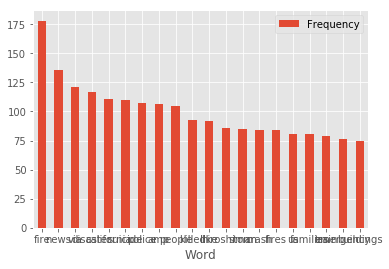

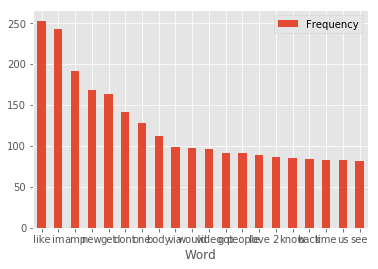

In [8]:

def clean_df(df):
    def remove_stopwords(text):
        if text is not None:
            tokens = [x for x in word_tokenize(text) if x not in stop]
            return " ".join(tokens)
        else:
            return None
    
    #TMP: TRY TO USE DEFAULT STRING FOR NONE. TODO: USE ROW["KEYWORDS"]
    #df['hashtag'] =df['hashtag'].apply(lambda x : "NO" if x is None else x)
    
    df["text"] = df['text'].apply(lambda x : x.lower())
    #df["hashtag"] = df['hashtag'].apply(lambda x : x.lower())
    
    #df['text'] =df['text'].apply(lambda x : remove_stopwords(x))
    #df['hashtag'] =df['hashtag'].apply(lambda x : remove_stopwords(x))
    
    
    


    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    df['text']=df['text'].apply(lambda x : remove_URL(x))
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    df['text']=df['text'].apply(lambda x : remove_html(x))
    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['text']=df['text'].apply(lambda x: remove_emoji(x))
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    df['text']=df['text'].apply(lambda x : remove_punct(x))
    
    df.text = df.text.replace('\s+', ' ', regex=True)
    return df
df = clean_df(df)
print("-- Word distrig Positive Class")

show_word_distrib(target=1, field="text")

print("-- Word distrib Negative Class")
show_word_distrib(target=0, field="text")



# Utils for models

In [9]:
def read_test(test_path="/kaggle/input/nlp-getting-started/test.csv"):
    
    my_df = pd.read_csv(test_path)
    
    res_df = my_df[['id']]
    my_df = my_df[['text']]
    
    add_hashtags(my_df)
    my_df = clean_df(my_df)
    print("Test DF: {}".format(my_df.head(10)))
    
    return my_df, res_df

def dump_preds(res_df, preds, out="default"):
    res_df['target'] = None
    
    for i, p in  enumerate(preds):
        res_df.ix[i, 'target'] = p
    
    res_df.to_csv(out, index = False)
    

def split_data(df, _t=True):
    X = df.text
    if _t:
        Y = df.target
        le = LabelEncoder()
        Y = le.fit_transform(Y)
        Y = Y.reshape(-1,1)
        return X, Y
    else:
        return X

    

# Baseline Models
We build a simple majority model and TFIDF + LogReg to check the problem hardness.

In [10]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

"""
Build a baseline TFIDF + LOGREG based just on text
"""
def build_tfidf_logreg(df):
    my_df = df[['text','target']]
    x_features = my_df.columns[0]
    x_data = my_df[x_features]
    Y = my_df["target"]

    x_train, x_validation, y_train, y_validation = model_selection.train_test_split(
        x_data.values, Y.values, test_size=0.2, random_state=7)
    
    # configure TfidfVectorizer to accept tokenized data
    # reference http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None)

    lr = LogisticRegression()
    tfidf_lr_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('lr', lr)])
    tfidf_lr_pipe.fit(x_train, y_train)
    
    return tfidf_lr_pipe

def test_tfidf_logreg(model, test_path="/kaggle/input/nlp-getting-started/test.csv"):
    
    my_df, res_df = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")
    
    #x_features = my_df.columns[0]
    x_data = my_df["text"].values

    preds = model.predict(x_data)
    
    #dump_preds(res_df, preds, out="res_tfidf_logreg4_0.csv")
    
    return res_df


"""
Build a majority model
"""
def test_majority_model(test_path="/kaggle/input/nlp-getting-started/test.csv"):
    
    my_df = pd.read_csv(test_path)
    
    res = my_df[['id']]
    res['target'] = 1
    
    res.to_csv("res_majority.csv", index = False)
    return res
    

#test_majority_model(test_path="/kaggle/input/nlp-getting-started/test.csv")
#0.42944

#tfidf_log_reg = build_tfidf_logreg(df)
#test_tfidf_logreg(tfidf_log_reg, test_path="/kaggle/input/nlp-getting-started/test.csv")
#0.63164






# Test Gradient Boosting
Here we check a gradient boosting classifier, which is a bit less shallow model w.r.t logistic regression. In fact we gain a 3% w.r.t LogReg

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_train, y_train = split_data(df)

test_df, res_df = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")
X_test = split_data(test_df, _t=False)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100)),
                     ])
#text_clf.fit(X_train, y_train)
#predicted = text_clf.predict(X_test)
#dump_preds(res_df, predicted, out="submission.csv")
#0.66462

Test DF:                                                 text             hashtag
0                 just happened a terrible car crash                  no
1  heard about earthquake is different cities sta...          earthquake
2  there is a forest fire at spot pond geese are ...                  no
3              apocalypse lighting spokane wildfires  Spokane, wildfires
4      typhoon soudelor kills 28 in china and taiwan                  no
5                      were shakingits an earthquake                  no
6  theyd probably still show more life than arsen...                  no
7                                    hey how are you                  no
8                                    what a nice hat                  no
9                                           fuck off                  no


# Test RNN Model
Here we test a simple LSTM model with Dropout. The experiment does not give better performances w.r.t gradient boosting.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

#Value tuned based on data analysis
max_words = 750
max_len = 160

def process_data(X, tok=None):
    if tok is None:
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(X)
    sequences = tok.texts_to_sequences(X)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    return sequences_matrix, tok

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def test_model(model, tok=None, test_path="/kaggle/input/nlp-getting-started/test.csv", cut=0.5):
    
    my_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")
    
    X = split_data(my_df, _t=False)
    sequences_matrix, tok = process_data(X, tok=tok)
    preds = model.predict(sequences_matrix)

    normalized_preds = []
    for p in preds:
        if p >= cut:
            normalized_preds.append(1)
            
        else:
            normalized_preds.append(0)
    #dump_preds(res, normalized_preds, out="res_rnn.csv")
    return res

def tune_cutoff(model, tok):
    
    x_tune = df['text'].values
    x_target = df[['target']]
    
    
    X, Y = split_data(df)
    sequences_matrix, tok = process_data(X, tok=tok)
    preds = model.predict(sequences_matrix)
    
    x_target["preds"] = preds
    
    accumulator = 0
    _0 = []
    max_0 = 0
    _1 = []
    min_1 = 0
    
    for i, row in x_target.iterrows():
        if row['target'] == 0:
            _0.append(row['preds'])
            if row['preds'] > max_0:
                max_0 = row['preds']
        else:
            _1.append(row['preds'])
            if row['preds'] < min_1:
                min_1 = row['preds']

    mean_0 = sum(_0)/len(_0)
    mean_1 = sum(_1)/len(_1)
    return max(mean_0, mean_1)/min(mean_0, mean_1)
    

#model = RNN()
#model.summary()
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
#X, Y = split_data(df)
#sequences_matrix, tok = process_data(X, tok=None)

#model.fit(sequences_matrix,Y,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

    
#cut = tune_cutoff(model, tok)

#test_model(model, tok=tok, cut=cut)
#0.57259
#autocut: 0.57055

# Test Glove LSTM
Here we check the usage of Glove embeddings. We first encode the sentence with average word Glove embedding and then we use a Bi-LSTM to classify the sample representation. 
We reach a new best of 79.45, meaning that the embedding direction seem to be valuable. We are gonna test some other newer embeddings.

In [13]:
import numpy as np 
import re  #regular expression
from bs4 import BeautifulSoup
import pandas as pd 
from sklearn import model_selection, preprocessing
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
vocab_size = 10000
embedding_dim = 100
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
validation_split = 0.10

def load_glove_vectors():
    print('Indexing word vectors.')
    #Many thanks to rtatman for hosting the GloVe word embeddings dataset on Kaggle
    #https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation
    GLOVE_DIR = '/kaggle/input/glove6b100dtxt/'
    embeddings_index = {}
    print(list(os.walk("/kaggle/input")))
    with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

def tokenize(df):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenizer.fit_on_texts(df.text)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    training_sequences = tokenizer.texts_to_sequences(df.text)
    training_padded = pad_sequences(training_sequences, maxlen = max_length, 
                                    padding = padding_type, truncating = trunc_type)
    print('Shape of the data vector is', training_padded.shape, df.target.shape)
    
    return training_sequences, training_padded, word_index, tokenizer

def prepare_embedding_layer(word_index, embeddings_index):
    print('Preparing the embedding matrix')
    num_words = min(vocab_size, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, index in word_index.items():
        if index >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word, np.zeros(embedding_dim, dtype='float32'))
        
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    embedding_layer = Embedding(num_words, embedding_dim, 
                           embeddings_initializer = Constant(embedding_matrix), 
                           input_length = max_length, 
                           trainable = False)
    
    
    return embedding_layer

def model(embedding_layer):
    
    METRICS = [
          metrics.BinaryAccuracy(name='accuracy'),
          metrics.Precision(name='precision'),
          metrics.Recall(name='recall'),
          metrics.AUC(name='auc')]

    sequence_input = Input(shape = (max_length, ))
    embedded_sequences = embedding_layer(sequence_input)
    x = Bidirectional(tf.keras.layers.LSTM(64))(embedded_sequences)
    x = Dropout(0.5)(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = 'sigmoid')(x)
    model =  Model(sequence_input, output)
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr = .0002) ,metrics = METRICS)
    return model

def test_model(model, test_df, tokenizer):
    test_sequences = tokenizer.texts_to_sequences(test_df.text)
    test_padded = pad_sequences(test_sequences, maxlen = max_length, 
                                    padding = padding_type, truncating = trunc_type)
    predictions = model.predict(test_padded)
    predictions = np.round(predictions).astype(int).flatten()
    dump_preds(res, predictions, out="submission.csv")

"""
embeddings_index = load_glove_vectors()
test_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")
training_sequences, training_padded, word_index,tokenizer = tokenize(df)
embedding_layer =  prepare_embedding_layer(word_index, embeddings_index)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(training_padded, 
                                                                          df.target, 
                                                                          test_size = validation_split, 
                                                                          random_state=1)

model = model(embedding_layer)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size = 64, epochs = 30, 
                    callbacks = [early_stopping],
                    validation_data = (X_valid, y_valid))

test_model(model, test_df, tokenizer)
#0.7945
"""

'\nembeddings_index = load_glove_vectors()\ntest_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")\ntraining_sequences, training_padded, word_index,tokenizer = tokenize(df)\nembedding_layer =  prepare_embedding_layer(word_index, embeddings_index)\n\nX_train, X_valid, y_train, y_valid = model_selection.train_test_split(training_padded, \n                                                                          df.target, \n                                                                          test_size = validation_split, \n                                                                          random_state=1)\n\nmodel = model(embedding_layer)\n\nearly_stopping = tf.keras.callbacks.EarlyStopping(\n    monitor=\'val_auc\', \n    verbose=1,\n    patience=10,\n    mode=\'max\',\n    restore_best_weights=True)\nhistory = model.fit(X_train, y_train, batch_size = 64, epochs = 30, \n                    callbacks = [early_stopping],\n                    validation

# BERT TfHub
Using the BERT TfHub module, we build a DNN using BERT Embeddings and a simple Dense layer with sigmoid on the top. 
This is the best scoring model so fa, reaching a best of 82.45%

In [14]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Bidirectional,  Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
import tensorflow_hub as hub

import tokenization

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    """
    x = Bidirectional(tf.keras.layers.LSTM(64))(sequence_output)
    x = Dropout(0.1)(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation = 'sigmoid')(x)
    #out = Dense(1, activation='sigmoid')(clf_output)
    """
    kernel_size = 5
    filters = 64
    pool_size = 4
    
    x = Dropout(0.1)(sequence_output)
    x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Bidirectional(tf.keras.layers.LSTM(64))(x)
    out = Dense(1, activation="sigmoid")(x)

    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

test_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

train_input = bert_encode(df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_df.text.values, tokenizer, max_len=160)
train_labels = df.target.values

model = build_model(bert_layer, max_len=160)
model.summary()


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.15,
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping]
)

test_pred = model.predict(test_input)
_t = []
for t in test_pred:
    if t < 0.5:
        _t.append(0)
    else:
        _t.append(1)
dump_preds(res, _t, out="submission.csv")
#82.45


Test DF:                                                 text             hashtag
0                 just happened a terrible car crash                  no
1  heard about earthquake is different cities sta...          earthquake
2  there is a forest fire at spot pond geese are ...                  no
3              apocalypse lighting spokane wildfires  Spokane, wildfires
4      typhoon soudelor kills 28 in china and taiwan                  no
5                      were shakingits an earthquake                  no
6  theyd probably still show more life than arsen...                  no
7                                    hey how are you                  no
8                                    what a nice hat                  no
9                                           fuck off                  no
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


# XLNet / RoBERTa in 4 lines!
Here the XLNet/ GPT-2 / RoBERTa evaluation using the huggingface simpletransformers.

In [15]:
!pip install simpletransformers
!git clone --recursive https://github.com/NVIDIA/apex.git
!pip install --upgrade --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/. 
import os
import shutil

shutil.rmtree('apex')
if os.path.exists("cache_dir"):
    shutil.rmtree('cache_dir')

if os.path.exists("outputs"):
    shutil.rmtree('outputs')

if os.path.exists("runs"):
    shutil.rmtree('runs')

import torch
import random 
import numpy as np

from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
seed = 98
"""
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

train_data = df[['text', 'target']]

print("Building Model")
train_args = {
    "train_batch_size": 16,
    'eval_batch_size': 4,
    "num_train_epochs": 10,
    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0.005,
    'max_seq_length': 200,  
    'save_model_every_epoch': False,
    'overwrite_output_dir': True,
    'save_eval_checkpoints': False,
    "gradient_accumulation_steps": 1,
    "overwrite_output_dir": True
}
model = ClassificationModel("xlnet", 'xlnet-base-cased', num_labels=2, args=train_args)
#model = ClassificationModel("xlmroberta", 'xlm-roberta-base', num_labels=2, args=train_args)


print("Training the model")
model.train_model(train_data)


test_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")

print("Model evaluation")
predictions, raw_outputs = model.predict(test_df['text'])

dump_preds(res, predictions, out="submission_xlnet.csv")
"""

     |████████████████████████████████| 102kB 3.1MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=bd837a1c44d54c273a5e7864059aa49e46dd1355de87adccd090f68e23a12561
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
Cloning into 'apex'...
remote: Enumerating objects: 5670, done.
remote: Total 5670 (delta 0), reused 0 (delta 0), pack-reused 5670
Receiving objects: 100% (5670/5670), 13.38 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (3673/3673), done.
/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Processing ./apex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... - \ | / - \ | / - \ | /

'\nrandom.seed(seed)\nnp.random.seed(seed)\ntorch.manual_seed(seed)\ntorch.cuda.manual_seed(seed)\ntorch.backends.cudnn.deterministic = True\n\ntrain_data = df[[\'text\', \'target\']]\n\nprint("Building Model")\ntrain_args = {\n    "train_batch_size": 16,\n    \'eval_batch_size\': 4,\n    "num_train_epochs": 10,\n    "use_early_stopping": True,\n    "early_stopping_patience": 3,\n    "early_stopping_delta": 0.005,\n    \'max_seq_length\': 200,  \n    \'save_model_every_epoch\': False,\n    \'overwrite_output_dir\': True,\n    \'save_eval_checkpoints\': False,\n    "gradient_accumulation_steps": 1,\n    "overwrite_output_dir": True\n}\nmodel = ClassificationModel("xlnet", \'xlnet-base-cased\', num_labels=2, args=train_args)\n#model = ClassificationModel("xlmroberta", \'xlm-roberta-base\', num_labels=2, args=train_args)\n\n\nprint("Training the model")\nmodel.train_model(train_data)\n\n\ntest_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")\n\nprint("Model eval

# Test SuperLearner ensemble
Finally we try a super-learner ensemble. Meaning that we use a set of models (also the previous BERT used) to classify the samples and then we use a meta-model to ingest these classification results (from all models) and classify the sample. 
It is ensured that this ensemble cannot perform worse than the best in the ensemble, so we could enhance the BERT model capabilities.


In [16]:
# example of a super learner model for binary classification

!pip install tamnun
from tamnun.bert import BertClassifier, BertVectorizer
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import TransformerMixin 
from tamnun.bert import BertClassifier, BertVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import copy

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
# create a list of base-models
def get_models():
    models = []
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None
    )
    lr = LogisticRegression()
    tfidf_lr_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('lr', lr)])
    dec_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('dt', DecisionTreeClassifier())])
    svc = Pipeline([('tfidf', tfidf_vectorizer), ('svc', SVC(gamma='scale', probability=True))])
    gaus = Pipeline([('tfidf', tfidf_vectorizer),('to_dense', DenseTransformer()),  ('gaus', GaussianNB())])
    kn = Pipeline([('tfidf', tfidf_vectorizer), ('kn', KNeighborsClassifier())])
    ada = Pipeline([('tfidf', tfidf_vectorizer), ('ada',AdaBoostClassifier())])
    bagging =  Pipeline([('tfidf', tfidf_vectorizer), ('bag',BaggingClassifier(n_estimators=10))])
    ran_forest = Pipeline([('tfidf', tfidf_vectorizer), ('ran',RandomForestClassifier(n_estimators=10))])
    extra_tree = Pipeline([('tfidf', tfidf_vectorizer), ('extr',ExtraTreesClassifier(n_estimators=10))])
    gradient_boosting = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(n_estimators=100)),
                     ])
    #bert =  Pipeline([('extr',BertVectorizer()), ("extr2",BertClassifier(num_of_classes=2))])
    
    module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
    bert_layer = hub.KerasLayer(module_url, trainable=True)

    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

    model = build_model(bert_layer, max_len=160)
    model.summary()
    
   # models.append(bert)
    models.append(model)
    models.append(dec_pipe)
    models.append(tfidf_lr_pipe)
    models.append(svc)
    models.append(gaus)
    models.append(kn)
    models.append(ada)
    models.append(bagging)
    models.append(ran_forest)
    models.append(extra_tree)
    models.append(gradient_boosting)
    
    return models, tokenizer

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models, tokenizer):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = StratifiedKFold(n_splits=5, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X, y):
		fold_yhats = list()
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for i, model in enumerate(models):
			if i == 0:
				train_input = bert_encode(train_X, tokenizer, max_len=160)
				early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)
				model.fit(train_input, train_y, validation_split=0.25, epochs=10,batch_size=16,  callbacks=[early_stopping])
				_test_X = bert_encode(test_X, tokenizer, max_len=160)
				yhat = model.predict(_test_X)
				_y = []
				for __y in yhat:
					one_prob = __y[0]
					zero_prob = 1 - one_prob
					_y.append([zero_prob, one_prob])
				yhat = _y
			else:
				model.fit(train_X, train_y)
				yhat = model.predict_proba(test_X)
			# store columns
			fold_yhats.append(yhat)
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models, bert_tok):
	for i,model in enumerate(models):
		if i == 0:
			train_input = bert_encode(X, bert_tok, max_len=160)
			early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)
			model.fit(train_input, y, validation_split=0.10, epochs=10,batch_size=16,  callbacks=[early_stopping])
		else:  
			model.fit(X, y)

# fit a meta model
def fit_meta_model(X, y):
	model = ExtraTreesClassifier(n_estimators=30)
	model.fit(X, y)
	return model


# make predictions with stacked model
def super_learner_predictions(X, models, meta_model, bert_tok):
	meta_X = list()
	for i, model in enumerate(models):
		if i == 0:
			x = bert_encode(X, bert_tok, max_len=160)
			yhat = model.predict(x)
			_y = []
			for y in yhat:
				one_prob = y[0]
				zero_prob = 1 - one_prob
				_y.append([zero_prob, one_prob])
			yhat =_y
		else:
			yhat = model.predict_proba(X)
		meta_X.append(yhat)
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)


"""
test_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")
X, y = split_data(df)
X_test = split_data(test_df, _t=False)

# get models
models, bert_tok = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models,bert_tok)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models, bert_tok)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate meta model
yhat = super_learner_predictions(X_test, models, meta_model, bert_tok)

print("YHat: {}".format(yhat))
dump_preds(res, yhat, out="submission_ensemble.csv")
"""

     |████████████████████████████████| 5.4MB 7.0MB/s 
     |████████████████████████████████| 13.9MB 40.1MB/s 
     |████████████████████████████████| 676.9MB 17kB/s 
ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
ERROR: tpot 0.11.1 has requirement numpy>=1.16.3, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tpot 0.11.1 has requirement scikit-learn>=0.22.0, but you'll have scikit-learn 0.20.2 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tensorflow-probability 0.8.0 has requirement cloudpickle==1.1.1, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: ray 0.8.0 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: osmnx 0.10 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: mxnet-cu100 1.5.1.post0 has requirem

'\ntest_df, res = read_test(test_path="/kaggle/input/nlp-getting-started/test.csv")\nX, y = split_data(df)\nX_test = split_data(test_df, _t=False)\n\n# get models\nmodels, bert_tok = get_models()\n# get out of fold predictions\nmeta_X, meta_y = get_out_of_fold_predictions(X, y, models,bert_tok)\nprint(\'Meta \', meta_X.shape, meta_y.shape)\n# fit base models\nfit_base_models(X, y, models, bert_tok)\n# fit the meta model\nmeta_model = fit_meta_model(meta_X, meta_y)\n\n# evaluate meta model\nyhat = super_learner_predictions(X_test, models, meta_model, bert_tok)\n\nprint("YHat: {}".format(yhat))\ndump_preds(res, yhat, out="submission_ensemble.csv")\n'

# Embedding Stacking!
Unfortunately the GPU allowed in Kaggle is not enough to keep multiple embeddings, if Elmo is one of them. So this is just an example code, witouth an official score.

In [17]:
!pip install flair
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings, StackedEmbeddings, BertEmbeddings, ELMoEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data import Sentence
import pandas as pd
from keras.layers import Input, Dense, GRU, Bidirectional, Flatten
from keras.optimizers import Adam
from keras.models import Model
import numpy as np


def generateTrainingData(dataset, batch_size, max_length, num_classes, emb_size,
                        stacked_embedding):
  
  x_batch = []
  y_batch = []
  while True:
    data = dataset.sample(frac=1)
    for index, row in data.iterrows():
 
        my_sent = row["text"]
        sentence = Sentence(my_sent)
        stacked_embedding.embed(sentence)
        
        x = []
        for token in sentence:
          x.append(token.embedding.cpu().detach().numpy())
          if len(x) == max_length:
            break
        
        while len(x) < max_length:
          x.append(np.zeros(emb_size))
        
        y = np.zeros(num_classes)
        y[row["target"]] = 1
        
        x_batch.append(x)            
        y_batch.append(y)

        if len(y_batch) == batch_size:
          yield np.array(x_batch), np.array(y_batch)

          x_batch = []
          y_batch = []

def generatePredictionData(dataset, batch_size, max_length, num_classes, emb_size, stacked_embedding):
  
  x_batch = []
  while True:
    for text in dataset['text'].values:
 
        my_sent = text
        sentence = Sentence(my_sent)
        stacked_embedding.embed(sentence)
        
        x = []
        for token in sentence:
          x.append(token.embedding.cpu().detach().numpy())
          if len(x) == max_length:
            break
        
        while len(x) < max_length:
          x.append(np.zeros(emb_size))
          
        x_batch.append(x)            
        if len(x_batch) == batch_size:
          yield np.array(x_batch)

          x_batch = []

def get_stacked_embeddings():
  stacked_embedding = StackedEmbeddings([ELMoEmbeddings(), WordEmbeddings("en")])
  print("Stacked embedding size: {}".format(stacked_embedding.embedding_length))
  embedding_size = stacked_embedding.embedding_length
  return stacked_embedding, embedding_size

def declare_model(batch_size, max_len, emb_size, gru_size, num_classes):
 
  sample = Input(batch_shape=(batch_size, max_len, emb_size))
  gru_out = Bidirectional(GRU(gru_size, return_sequences=True))(sample)
  gru_out = Flatten()(gru_out)
  predictions = Dense(num_classes, activation='sigmoid')(gru_out)

  model = Model(inputs=sample, outputs=[predictions])
  model.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=["acc"])
  print(model.summary())

  return model

"""
BATCH_SIZE = 256
MAX_LEN = 150
GRU_SIZE = 20
NUM_CLASSES=2 
EPOCHS = 1

stacked_embedding, embedding_length = get_stacked_embeddings()

m = declare_model(batch_size=BATCH_SIZE, max_len=MAX_LEN, emb_size=embedding_length, gru_size=GRU_SIZE, num_classes=NUM_CLASSES)


gen = generateTrainingData(df, batch_size=BATCH_SIZE, max_length=MAX_LEN, num_classes=NUM_CLASSES, emb_size=embedding_length,
  stacked_embedding= stacked_embedding)
print(gen)
steps_per_epoch = len(df)/BATCH_SIZE
m.fit_generator(gen, steps_per_epoch=1, epochs=EPOCHS, workers=1)

df_test = df[:10]
test_gen = list(generatePredictionData(df_test,  batch_size=BATCH_SIZE, max_length=MAX_LEN, num_classes=NUM_CLASSES, 
        emb_size=embedding_length, stacked_embedding=stacked_embedding))

print(np.argmax(m.predict_generator(test_gen, steps=1), axis=1))
"""



     |████████████████████████████████| 143kB 4.8MB/s 
     |████████████████████████████████| 235kB 43.7MB/s 
     |████████████████████████████████| 7.1MB 38.8MB/s 
     |████████████████████████████████| 122kB 37.9MB/s 
     |████████████████████████████████| 1.7MB 33.3MB/s 
  Created wheel for sqlitedict: filename=sqlitedict-1.6.0-cp36-none-any.whl size=14689 sha256=00b6bc411a3ba9e852eea9f17dfb9f9418bcc842e802c83b5023e58d74e9ac22
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23258 sha256=130b67c6f02508d549395398fc0239e717193a1ea392083430c57cdf3b491c65
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Created wheel for networkx: filename=networkx-2.2-py2.py3-none-any.whl size=1527322 sha256=50155dcc6407d97426ae65f645d2396a04631d3200aa3d7f4826445bb174d21f
  Stored in directory: /root/.cache/pip

ImportError: cannot import name 'lobpcg'